#### Feature Selection :
    Process of selecting the subset of features that are most useful/relevant for the problem we are working on.
    
    Feature Extraction/ Dimension reduction is the reduction of features by creating new combinations of attributes using techniques like PCA, SVD etc, where as feature selection methods include and exclude attributes present in the data without changing them.
    
    FS reduces features/dimension which helps to increase performance of predictors, create less complex models, fast and effective and easy to interpret models

#### Types of Feature Selection:
    1. Filter methods - 
        > Unsupervised(independent on target) or supervised(uses target)
        > Works either on univariate features or along with target variable. Uses statistical scoring methods to rank the importance of features
        > [Covariance matrix, correleation coefficient, correlation matrix, Pearson's correlation coefficient, Spearman's correlation, Mutual information, Chi square test, ANOVA, KendallTau]
       -----------------------------------------------------------------------------------------------------------
     
     2.Wrapper Methods - 
        > Supervised
        > Considers the selection of set of features as a search problem. It selects subset of features and run different combination of classifiers with those features and evaluate the performance to all the combinations.This goes recursively and remove the features based on models accuracy scores. It can use forward elimination or backward elimination techniques.
        > [Recursive Feature Elimination (RFE), RFECV (RFE with cross validation helps to choose best hyperparameters for RFE), Forward Pass, Backward Pass]
        > RFE works by searching for a subset of features by starting with all features in the training dataset and successfully removing features until the desired number remains.(backward)
        
        ----------------------------------------------------------------------------------------------------------
        
    3.Embedded/Intrinsix Methods
        > Bake in feature selection.Performs feature selection automatically as part of learning the model. Meaning that the model will only include predictors/variables/features that help maximize accuracy.
        > Learns which features are contributing more to the model accuracy during model training
        > [Regularisation methods like Lasso, Elastic Net, Ridge regression, Random forest, Extra trees, Neural networks]
        

#### Tips on when is best to do feature selection:
    > When cross validation is in the pipeline, its best practice to include feature selection within the inner-loop when you are using accuracy estimation methods such as cross-validation. This means that feature selection is performed on the prepared fold right before the model is trained. A mistake would be to perform feature selection first to prepare your data, then perform model selection and training on the selected features. If you perform feature selection on all of the data and then cross-validate, then the test data in each fold of the cross-validation procedure was also used to choose the features and this is what biases the performance analysis.
    
    > Perform feature selection on a different dataset than you train your predictive model on … the effect of not doing this is you will overfit your training data.
    

#### ------------------Embedded Feature selection using ExtraTrees---------------------------------

In [27]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split
from sklearn.datasets import load_iris
import pandas as pd
import matplotlib.pyplot as plt

data = load_iris(as_frame=True)

X = data.data
Y = data.target
print("Training data shapes: X-{} Y-{}".format(X.shape, Y.shape))


clf = ExtraTreesClassifier()
clf.fit(X, Y) 
#fit will do the calculations that are required for the formula or algorithm (StandardScaler)
#transform will apply the calculations of fit object to each datapoint of the feature inorder to transform
#Note: for training data transformations, we have to use fit and transform.For test data, only transform as fit introduces bias
print(clf.feature_names_in_)
print(clf.feature_importances_)


Training data shapes: X-(150, 4) Y-(150,)
['sepal length (cm)' 'sepal width (cm)' 'petal length (cm)'
 'petal width (cm)']
[0.09512607 0.06467933 0.38406994 0.45612465]


#### Observation: 
    Embedded classifier performs bake in feature selection and the features are identified using feature importances.

#### --------------------------- Wrapper Feature Selection - RFE ---------------------------------------------

In [33]:
#Example 1:
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
Y = data.target

model = RandomForestClassifier()
rfe = RFE(model, n_features_to_select=2, step=1)
rfe.fit(X, Y)
print(rfe.support_) #gives mask of the features
print(rfe.ranking_) #gives 1 to best selected features

#Info : After the class is fit, the choice of input variables can be seen via the “support_” attribute.
#It can then be applied to the training and test datasets by calling the transform() function.

[False False  True  True]
[2 3 1 1]


#### Observation : 
    It is clear that Sepal Length and Sepal Width are not correlating much with the target. It also matches with ExtraTrees Feature importances in the previous block.

##### RFE has 2 hyperparameters to choose. 
    1. Model
    2. No. of features to select
    
    We can explore different combinations of these 2 hyperparameters to make best use of RFE

#### --------------------- RFE in Classification ----------------------

In [2]:
from numpy import mean, std
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, train_test_split
from sklearn.feature_selection import RFE, RFECV
from sklearn.pipeline import Pipeline

X, Y = make_classification(n_samples=800, n_features=10, n_classes=2, n_informative=7, n_redundant=3)
# Info: We can use make_classification() function to create a synthetic classification problem of 800 exmpls and 10 i/p features
print("Shapes : X- {}, Y- {}".format(X.shape, Y.shape))

#Info: During model training, we usually use cross validation. It is advisable to use feature selection 
#techniques like RFE in the inner loop of cross validation. Best option is to make use of in pipeline

rfe = RFE(estimator=ExtraTreesClassifier(), n_features_to_select=7, step=1)
clf = SGDClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=15, random_state=0)
pipe = Pipeline([('sel', rfe), ('mdl', clf)])

#Sampling
x_train , x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=True, random_state=0)
scores = cross_val_score(pipe, x_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1, error_score='raise')

print("Training Accuracy: {}, Std: {}".format(mean(scores), std(scores)))

#Info: We can also use the pipeline to fit the training data and predict the test dataset
#Info: For transformer call in the pipeline,when the pipe is initialised by creating an object, then init() constructor of the transformer is called
#Info: In case of transformations in the pipeline, when we call fit on pipe, it will also call fit() and also transform().When we call transform on pipe, it will call transform()
#Info: When we call predict on pipe, it will also call transform() and then predict()

pipe.fit(x_train, y_train)
y_preds = pipe.predict(x_test)
print("Test Accuracy: {}".format(accuracy_score(y_test, y_preds)))
print(rfe.support_)
print(rfe.ranking_)

Shapes : X- (800, 10), Y- (800,)
Training Accuracy: 0.6857815047752155, Std: 0.0789540336524148
Test Accuracy: 0.7159090909090909
[False  True  True False False  True  True  True  True  True]
[2 1 1 3 4 1 1 1 1 1]


#### --------------------------- RFE for Regression ------------------------

In [70]:
from sklearn.datasets import make_regression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.linear_model import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

X, Y = make_regression(n_samples=1000, n_features=10, n_informative=5, n_targets=1, random_state=0)

x_train , x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=True, random_state=0)

rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=5)
model = DecisionTreeRegressor()
cv = RepeatedKFold(n_repeats=3, n_splits=10, random_state=0)
pipe = Pipeline([('fs', rfe), ('est', model)])

scores = cross_val_score(pipe, x_train, y_train, cv=cv, error_score='raise', scoring='neg_mean_absolute_error')
print("Training CV MAE: {}".format(mean(scores)))

pipe.fit(x_train, y_train)
print("Test Accuracy: %.2f" % pipe.score(x_test, y_test))

Training MAE: -30.11397767400821
Test Accuracy: 0.87


#### ----------------------------- RFE Hyperparameter tuning - n_features_to_select ------------------------------

For 1 features , the score is: 0.76
For 2 features , the score is: 0.82
For 3 features , the score is: 0.84
For 4 features , the score is: 0.86
For 5 features , the score is: 0.88
For 6 features , the score is: 0.88
For 7 features , the score is: 0.88
For 8 features , the score is: 0.88
For 9 features , the score is: 0.88


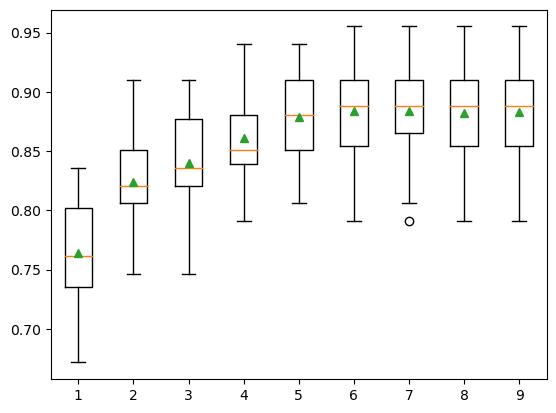

In [91]:
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

def get_data():
    X, Y = make_classification(n_samples=1000, n_features=10, n_informative=6)
    return X, Y

def evaluate(estimator, X, Y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
    scores = cross_val_score(estimator, X, Y, cv=cv, error_score='raise', scoring='accuracy')
    return scores

def rfe_no_of_features_tuning():
    rfe_models = dict()
    #Supplying different number of features to rfe and creating several models configurations
    for i in range(1, 10):
        rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i, step=1)
        model = LogisticRegression()
        rfe_models[str(i)] = Pipeline([('s', rfe), ('m', model)])
    return rfe_models

X, Y = get_data()
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0)
models = rfe_no_of_features_tuning()
names , results = [], []

for name, mdl in models.items():
    score = evaluate(mdl, x_train, y_train)
    results.append(score)
    names.append(name)

for i in range(len(names)):
    print("For %.2s features , the score is: %.2f" % (names[i], mean(results[i])))

plt.boxplot(results, labels=names, showmeans=True)
plt.show()

#### ---------------------------------- Tuning RFE hyperparameter - estimator  ---------------------------------------

For lr model , the score is: 0.87
For pe model , the score is: 0.85
For ca model , the score is: 0.88
For rf model , the score is: 0.88
For gb model , the score is: 0.89


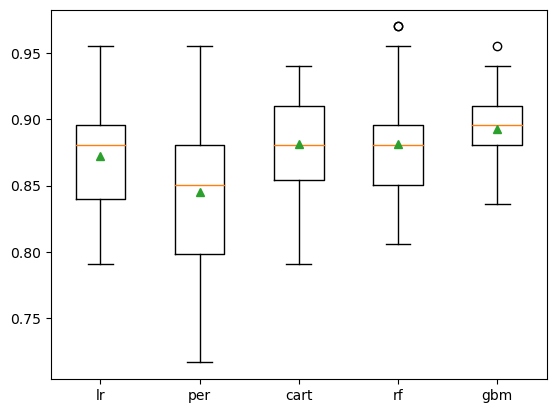

In [105]:
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

def get_data():
    X, Y = make_classification(n_samples=1000, n_features=10, n_informative=6)
    return X, Y

def evaluate(estimator, X, Y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
    scores = cross_val_score(estimator, X, Y, cv=cv, error_score='raise', scoring='accuracy')
    return scores

def rfe_estimator_tuning():
    rfe_models = dict()
   # lr
    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    rfe_models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
    # perceptron
    rfe = RFE(estimator=Perceptron(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    rfe_models['per'] = Pipeline(steps=[('s',rfe),('m',model)])
    # cart
    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    rfe_models['cart'] = Pipeline(steps=[('s',rfe),('m',model)])
    # rf
    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    rfe_models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
    # gbm
    rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    rfe_models['gbm'] = Pipeline(steps=[('s',rfe),('m',model)])
    return rfe_models

X, Y = get_data()
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0)
models = rfe_estimator_tuning()
names , results = [], []

for name, mdl in models.items():
    score = evaluate(mdl, x_train, y_train)
    results.append(score)
    names.append(name)

for i in range(len(names)):
    print("For %.2s model , the score is: %.2f" % (names[i], mean(results[i])))

plt.boxplot(results, labels=names, showmeans=True)
plt.show()

#### -------------------------------- Automatically select the no of features using RFECV---------------------------------

cv score using rfecv is: 0.73
Test accuracy: 0.74
Feature: 0 support: False, score: 6
Feature: 1 support: True, score: 1
Feature: 2 support: False, score: 2
Feature: 3 support: True, score: 1
Feature: 4 support: True, score: 1
Feature: 5 support: True, score: 1
Feature: 6 support: False, score: 3
Feature: 7 support: False, score: 4
Feature: 8 support: True, score: 1
Feature: 9 support: False, score: 5


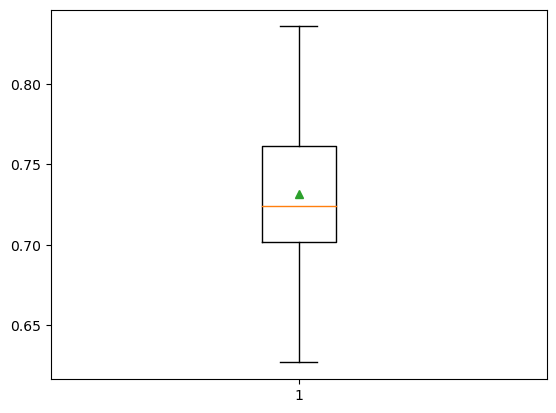

In [4]:
#Info: RFECV performs cross-validation evaluation of different numbers of features as we did in the previous section 
#and automatically selects the number of features that resulted in the best mean score.

from sklearn.datasets import make_classification
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

def get_data():
    X, Y = make_classification(n_samples=1000, n_features=10, n_informative=6)
    return X, Y

def evaluate(estimator, X, Y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
    scores = cross_val_score(estimator, X, Y, cv=cv, error_score='raise', scoring='accuracy')
    return scores

X, Y = get_data()
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0)
customied_cv = RepeatedKFold(n_repeats=4, n_splits=10, random_state=0)
rfecv = RFECV(estimator=DecisionTreeClassifier(), min_features_to_select=2, cv=customied_cv)
model = LogisticRegression()
pipe = Pipeline([('s', rfecv), ('mdl', model)])
scores = evaluate(pipe, x_train, y_train)
print("cv score using rfecv is: %.2f" % (mean(scores)))
pipe.fit(x_train, y_train)
print("Test accuracy: %.2f"%(pipe.score(x_test, y_test)))

#Finding out the best params
for i in range(x_train.shape[1]):
    print("Feature: {} support: {}, score: {}".format(i , rfecv.support_[i], rfecv.ranking_[i]))
    
plt.boxplot(scores, showmeans=True)
plt.show()

#### ------------------------------- Filter Methods -------------------------------------

    Filter methods uses statistical scores to evaluate each feature.Mostly covariance and correlation.Lets see what is covriance and correlation means.

    Correlation: It is the statiscal summary of relationship(cause/depend/associate) between variables.Correlation can be postive, negative or neutral.If 2 or more variables are tightly related then the situation is called Multicollinearity.

    Covaraince matrix:  Summarizes the linear relationship between variables

    Pearson correlation coef: Summarizes the linear relationship between variables

    Spearman correlation coef: Summarize the monotonic(increase/decrease) relationship between variables

    Note: The structure of the relationship may be known, e.g. it may be linear, or we may have no idea whether a relationship exists between two variables or what structure it may take. Depending what is known about the relationship and the distribution of the variables, different correlation scores can be calculated.

x1 Mean- 100.43033655713802 , Standard Deviation - 20.115428104120635
x2 Mean- 150.35811986458052 , Standard Deviation - 22.464847306590126


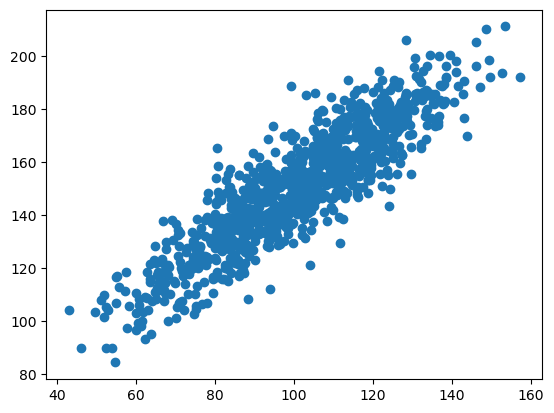

In [107]:
#Example to understand correlation:
from numpy.random import randn, seed
import matplotlib.pyplot as plt

#Info: randn returns a sample (or samples) from the "standard normal" distribution.
#we can use randn() to generate guassian distribution synthetically of mean 0 and standard deviation 1 (standardised data)

#lets create 2 features. One with mean 100 and sd 20.
#Another feature will be created from first feature with mean 50 and sd 10 which implies that both are highly correlated

#Info: Inorder to customise the distribution of default randn distrubution, we can multiply it with our sd and add our mean

#The pseudorandom number generator is seeded to ensure that we get the same sample of numbers each time the code is run.
seed(1)

#Creating first feature for 1000 samples
x1 = 20 * randn(1000) + 100

#Creating second feature from first sample that resembles correlation btwn features x1 and x2
x2 = x1 + (10 * randn(1000) + 50)

print("x1 Mean- {} , Standard Deviation - {}".format(mean(x1), std(x1)))
print("x2 Mean- {} , Standard Deviation - {}".format(mean(x2), std(x2)))

#Plotting using scatter plot to visualise the relationship between two variables
plt.scatter(x1, x2)
plt.show()

#### Observation:
    The realtionship shows the increasing trend which implies positive correlation.

#### Covariance:
    variance of some random variable X is a measure of how much values in the distribution vary on average with respect to the mean.It describes the spread of observation from the mean.
    
    Covariance is the measure of the joint probability for two random variables. Covariance is a statistical term that refers to a systematic relationship between two random variables which describes how the two variables change together.
    
    Covariance is great for defining the type of relationship, but it's terrible for interpreting the magnitude.
        cov(X, Y) = (sum (x - mean(X)) * (y - mean(Y)) ) * 1/(n-1)
        
        Note: Mean is also called as expected value E. Variance(X) = sigma^2 = sum( (x1 - E[X])^2,.. (xn - E[X])^2) / n-1.
        Note : E[X] = mean(X) = mu = X bar
        Info: The sum of the squared differences is multiplied by the reciprocal of the number of examples minus 1 to correct for a bias.
    
    How cov is different from corr?
        In statistics, correlation is a measure that determines the degree to which two or more random variables move in sequence. When an equivalent movement of another variable reciprocates the movement of one variable in some way or another during the study of two variables, the variables are said to be correlated.
        Correlation uses covariance to identify the relationship.Correlation is the normalized version of covariance to achieve the score between -1 and 1 to make the magnitude interpretable by dividing it by the standard deviation of X and Y
        corr(X, Y) = cov(X, Y) / (sqrt(var(X)) *sqrt(var(Y))) where sqrt(var(X)) = standard deviation of X

    Note : When  the values of a variable are subtracted from its mean, then that means the values are centered.Meaning, By subtracting mu, the mean has been shifted to 0, by dividing by sigma the standard deviation has been changed to 1.
    Note: Standardisation means transforming the values to have mean of 0 and sd of 1
    Note: Use of the mean in the calculation suggests the need for each data sample to have a Gaussian or Gaussian-like distribution.
    Note: Sign of the covariance can be interpreted as whether the two variables change in the same direction (positive) or change in different directions (negative). 0 indicates no relation.The magnitude of the covariance is not easily interpret as the value range from -infinity to +infinity.

In [109]:
from numpy.random import randn, seed
from numpy import cov

seed(1)
x1 = 20 * randn(1000) + 100
x2 = x1 + (10 * randn(1000) + 50)
covariance = cov(x1, x2) # return covariance matrix
print(covariance)

[[397.92502248 399.41734496]
 [399.41734496 493.73799609]]


#### Observation: 
    Covariance shows positive relation(399.41).It is important to know that covariance is best choice if the distribution represents Gaussian and there is linear relationship between variables.But covariance is hard to interpret.Hence Pearson's correlation coefficiet is introduced

#### --------------------------- Pearson's Correlation coefficient-----------------------------

    It is used to summarize the strength of the linear relationship between two data samples.
        Pearson's corr coef(x1, x2) = cov(x1, x2) / sd(x1) . sd(x2)
    It is the normalization of the covariance between the two variables to give an interpretable score.

    Note: 
    The use of mean and standard deviation in the calculation suggests the need for the two data samples to have a Gaussian or Gaussian-like distribution.

    Note:
    The coefficient returns a value between -1 and 1 that represents the limits of correlation from a full negative correlation to a full positive correlation. A value of 0 means no correlation. The value must be interpreted, where often a value below -0.5 or above 0.5 indicates a notable correlation, and values below those values suggests a less notable correlation.

In [6]:
from numpy.random import randn, seed
from scipy.stats import pearsonr
import numpy as np

seed(1)
x1 = 20 * randn(1000) + 100
x2 = x1 + (10 * randn(1000) + 50)
pearson_corr = pearsonr(x1, x2) # return covariance matrix
print(pearson_corr)
print(pearson_corr.statistic)
print(pearson_corr.confidence_interval(confidence_level=0.95)) 
#This method computes the confidence interval of the correlation coefficient `statistic` for the given confidence level.

#if we want to test pearson corr coef for more than 2 values, 
#we can corrcoef() from numpy or pandas corr() when dealing with pd series/df

x3 = 30 * randn(1000) + 45
corr_coef_matrix = np.corrcoef(x2, x3)
print(corr_coef_matrix)

PearsonRResult(statistic=0.887611908579531, pvalue=0.0)
0.887611908579531
ConfidenceInterval(low=0.8736945670871663, high=0.9000775077039672)
[[ 1.         -0.05924545]
 [-0.05924545  1.        ]]


#### Observation : 
    Represents high postive correlation between x1 and x2.Represents less negative correlation between x2 and x3

In [7]:
#another example for pearson's calculation
np.set_printoptions(linewidth=200, edgeitems=20)
xyz = np.array([[10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
                [2, 1, 4, 5, 8, 12, 18, 25, 96, 48],
                [5, 3, 2, 1, 0, -2, -8, -11, -15, -16]]) #we are creating a 3d array.
print(xyz)
print(np.corrcoef(xyz))
print("-----------------------------------")
print(np.corrcoef(xyz, rowvar=False))
# print(np.corrcoef(xyz.T))

[[ 10  11  12  13  14  15  16  17  18  19]
 [  2   1   4   5   8  12  18  25  96  48]
 [  5   3   2   1   0  -2  -8 -11 -15 -16]]
[[ 1.          0.75864029 -0.96807242]
 [ 0.75864029  1.         -0.83407922]
 [-0.96807242 -0.83407922  1.        ]]
-----------------------------------
[[ 1.          0.98198051  0.84169758  0.75592895  0.55191089  0.30450771  0.07410807 -0.06981111 -0.57300929 -0.32042431]
 [ 0.98198051  1.          0.92857143  0.8660254   0.6995586   0.47902808  0.26123525  0.11996801 -0.40780377 -0.13563245]
 [ 0.84169758  0.92857143  1.          0.98974332  0.9148074   0.77061039  0.60084108  0.47987205 -0.03978573  0.24177958]
 [ 0.75592895  0.8660254   0.98974332  1.          0.96312314  0.85375027  0.70887395  0.60028423  0.10336637  0.37791847]
 [ 0.55191089  0.6995586   0.9148074   0.96312314  1.          0.96236205  0.87251109  0.79333905  0.36717428  0.61308916]
 [ 0.30450771  0.47902808  0.77061039  0.85375027  0.96236205  1.          0.97245715  0.92892794  0.

#### Observation:
    In the example above, 
    When 3d/2d array is created, the rows represents features and the columns represents observaions.
    #corrcoef() also considers the rows(3) as features and columns as observations. That’s because there are 3 rows.
    #The usual practice in machine learning is the opposite: rows are observations and columns are features.
    #In this case we can transpose it. or we can use rowvar=False.

#### ------------------------------- Spearman's correlation ------------------------------------

    Two variables may be related by a nonlinear relationship, such that the relationship is stronger or weaker across the distribution of the variables.Further, the two variables being considered may have a non-Gaussian distribution.Then we can use Spearman's correlation coefficient. This is a common approach used in non-parametric statistics, e.g. statistical methods where we do not assume a distribution of the data such as Gaussian.The scores are between -1 and 1 for perfectly negatively correlated variables and perfectly positively correlated respectively.

    Instead of calculating the coefficient using covariance and standard deviations on the samples themselves, these statistics are calculated from the relative rank of values on each sample.Here, a linear relationship between the variables is not assumed, although a monotonic relationship(increasing / decreasing) is assumed.

    Spearman's corr coeff(X, Y) = cov(rank(X), rank(Y)) / (std(rank(X)) * std(rank(Y)))


In [8]:
from numpy.random import randn, seed
from scipy.stats import spearmanr
import numpy as np
import pandas as pd

seed(1)
x1 = 20 * randn(1000) + 100
x2 = x1 + (10 * randn(1000) + 50)
spearman_corr, _ = spearmanr(x1, x2) # return covariance matrix
print(spearman_corr)

#we can also pandas corr() when dealing with pd series/df
data = pd.DataFrame({'x1': x1, 'x2': x2})
corr_coef = data.corr(method='spearman')
print(corr_coef)

0.8724050484050484
          x1        x2
x1  1.000000  0.872405
x2  0.872405  1.000000


#### ------------------------------- Chi squared Test -------------------------------------------------

    - Pearson's Chi squared test is a statistical hypothesis test for quantifying the independence of pairs of categorical variables. When the input is categorical and also the output is categorical, then we use chi-squared statistical hypothesis which is an example of a test for independence between categorical variables.It is non parametric test.Nonparametric tests are used for data that don’t follow the assumptions of parametric tests, especially the assumption of a normal distribution.
    If you want to test a hypothesis about the distribution of a categorical variable you’ll need to use a chi-square test or another nonparametric test. Categorical variables can be nominal or ordinal. Because they can only have a few specific values, they can’t have a normal distribution.
    
    -Chi squared test tests for independence with the help of null hypothesis, alternate hypothesis, critical value, contingenecy table, statistic, p-value, alpha.
    
    
    -- chi-squares is used to determine whether your observed data are significantly different from what you expected.2 types
            -> chi-square goodness of fit test 
                (test whether the frequency distribution of a categorical variable is different from your expectations) (Expectation is our null hypothesis)
            -> chi-square test of independence
                ( test whether two categorical variables are related to each other)
            ->  chi-square test of homogeneity
                (tests whether two populations come from the same distribution by determining whether the two populations have the same proportions as each other)
            -> X^2 = Sigma(O-E)^2/E
            -> To decide whether the difference is big enough to be statistically significant, you compare the chi-square value to a critical value.
            
     
    -----------------------------------------------------------------------------------
    ------------------------------- Working--------------------------------------------
    -----------------------------------------------------------------------------------
        - Create a table of the observed and expected frequencies. (Contigency table)
        - Calculate the chi-square value from your observed and expected frequencies using the chi-square formula.
        - Find the critical chi-square value in a chi-square critical value table or using statistical software.
        - Compare the chi-square value to the critical value to determine which is larger.
        - Decide whether to reject the null hypothesis.
            Eg: H0: both the variables(feature and target) are dependent
        - Reject the null hypothesis if chi-square value/statistic >= critical value
        (If you reject the null hypothesis, you can conclude that your data are significantly significant and is independent from each other)
        - If statistic < critical value, fail to reject null hypothesis (both the variables(feature and target) are dependent) 
    - Likewise If p-value <= alpha: --> independent.If p-value > alpha: dependent
    
    
    Statistical significance is arbitrary – it depends on the threshold, or alpha value, chosen by the researcher. A common alpha value is 0.05, which means that there is a 5% chance of obtaining the observed results if the null hypothesis is true.

    To test the null hypothesis, researchers calculate a test statistic using their data and compare it to a critical value based on the alpha value and the distribution of the test statistic. If the test statistic is more extreme than the critical value, they reject the null hypothesis and conclude that their results are statistically significant. If not, they fail to reject the null hypothesis and conclude that their results are not statistically significant.

    For example, suppose you want to test whether there is a difference in the average height of men and women in a population. You collect a random sample of 100 men and 100 women and measure their heights. You perform a t-test to compare the means of the two groups. The null hypothesis is that there is no difference in the mean heights of men and women. The alternative hypothesis is that there is a difference.

    You set your alpha value at 0.05 and calculate your test statistic using a formula or software. You also find the critical value for a two-tailed t-test with 198 degrees of freedom using a table or software. Suppose your test statistic is 3.5 and your critical value is 1.96. Since your test statistic is greater than your critical value, you reject the null hypothesis and conclude that there is a statistically significant difference in the mean heights of men and women.

#### -------------- McNemar’s test ------------------ 
    It is a test that uses the chi-square test statistic. It isn’t a variety of Pearson’s chi-square test, but it’s closely related. 

    McNemar test is a non-parametric test for paired nominal data. It’s used when you are interested in finding a change in proportion for the paired data.It allows you to determine whether the proportions of the variables are equal.

    For example, you could use this test to analyze retrospective case-control studies, where each treatment is paired with a control. It could also be used to analyze an experiment where two treatments are given to matched pairs.You can conduct this test when you have a related pair of categorical variables that each have two groups. 

    Requirements to perform McNemar's:
    -----------------------------------------------------
    - You must have one nominal variable with two categories (i.e. dichotomous variables) and one independent variable with two connected groups.
    - The two groups in your the dependent variable must be mutually exclusive. In other words, participants cannot appear in more than one group.
    - Your sample must be a random sample.

    Suppose that a sample of 100 people is offered two flavors of ice cream and asked whether they like the taste of each.

    Contingency table of ice cream flavor preference
    --------------------------------------------------

                 Like chocolate	 Dislike chocolate
                
    Like vanilla	   47 (a)	         32 (b)
    Dislike vanilla	    8 (c)            13 (d)
    
    Null hypothesis (H0): The proportion of people who like chocolate is the same as the proportion of people who like vanilla.
    Alternative hypothesis (HA): The proportion of people who like chocolate is different from the proportion of people who like vanilla.

                        Formula: X^2 = (b-c)^2 / (b+c)

In [9]:
#----------------------------Chi squared test using breast cancer data set-------------------------------------------
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest, f_classif, f_regression, SelectPercentile
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

#loading the data from csv file
def load_data(filepath):
    data_csv = pd.read_csv(filepath)
    data = data_csv.values
    X = data[:, 1:]
    Y = data[:, 0]
    X = X.astype(str) #sometimes pandas tries to convert few features to integers.Hence making sure everything to be string/categorical
    return X, Y

#Encoding the categorical input features
def prepare_input(train, test):
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10000)
    #Best practice is to fit the encoder first to training set and then apply the transform to train and test set
    oe.fit(train)
    X_train_enc = oe.transform(train)
    X_test_enc = oe.transform(test)
    return X_train_enc, X_test_enc

#Encoding the categorical output using label encoder(ordinal encodes single variable)
def prepare_output(train, test):
    le = LabelEncoder()
    le.fit(train)
    Y_train_enc = le.transform(train)
    Y_test_enc = le.transform(test)
    return Y_train_enc, Y_test_enc

#Loading the data
X, Y = load_data("E:\Learning\ML\Datasets\data\\breast-cancer.data")

#Splitting the data
x_train, x_test, y_train, y_test = train_test_split(X , Y, test_size=0.33, random_state=0, shuffle=True)

#Encoding
X_train_enc, X_test_enc = prepare_input(x_train, x_test)
Y_train_enc, Y_test_enc = prepare_output(y_train, y_test)

Feature: 0 , score: 1.298539
Feature: 1 , score: 2.675842
Feature: 2 , score: 1.464480
Feature: 3 , score: 68.924866
Feature: 4 , score: 2.028543
Feature: 5 , score: 7.356049
Feature: 6 , score: 0.913137
Feature: 7 , score: 2.021197
Feature: 8 , score: 3.499851


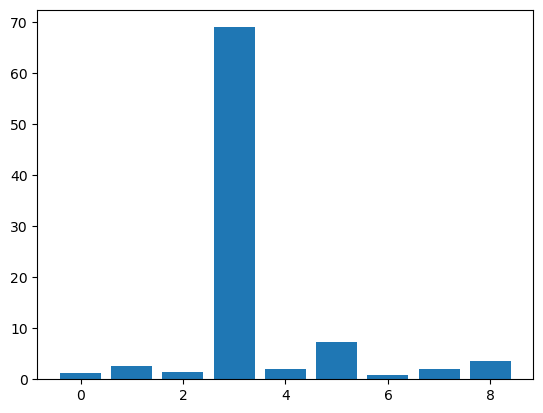

CV score - all features 0.778947
Chi square - all features - Training accuracy: 0.810526
 Chi square - all features - Test accuracy: 0.684211


In [10]:
#Using the SelectKBest with chi2() to find out the best features
chi_fs = SelectKBest(score_func=chi2, k='all')
#Here we are specifying k as all for now.Just to plot and visualise all the feature scores.
chi_fs.fit(X_train_enc, Y_train_enc)
X_train_fs = chi_fs.transform(X_train_enc)
X_test_fs = chi_fs.transform(X_test_enc)

#print the scores
for i in range(len(chi_fs.scores_)):
    print("Feature: %d , score: %f" %(i, chi_fs.scores_[i])) #Chi square scores for each feature of input
#plotting
plt.bar([i for i in range(len(chi_fs.scores_))], chi_fs.scores_)
plt.show()


#Lets train the model with all the features to check the performance
cv = KFold(n_splits=10, random_state=0, shuffle=True)
model = LogisticRegression(solver='lbfgs')
score = cross_val_score(model, X_train_fs, Y_train_enc, 
                        cv=cv, scoring='accuracy',
                        error_score='raise', n_jobs=-1)
print("CV score - all features %f"%mean(score))
model.fit(X_train_fs, Y_train_enc)
y_train_preds = model.predict(X_train_fs)
print("Chi square - all features - Training accuracy: %f" %(accuracy_score(Y_train_enc, y_train_preds)))
y_pred = model.predict(X_test_fs)
print(" Chi square - all features - Test accuracy: %f" %(accuracy_score(Y_test_enc, y_pred)))


#### Observation:
    Looks like features 3,5,8,1 are relevant features to target according to Chi square.Lets use k as 4 in the next step to select the features

In [11]:
#Selecting 4 best features with chi2
chi = SelectKBest(score_func=chi2, k=4)
chi.fit(X_train_enc, Y_train_enc)
X_train_best_fs = chi.transform(X_train_enc)
X_test_best_fs = chi.transform(X_test_enc)

#Training the Model
cv = KFold(n_splits=10, random_state=0, shuffle=True)
model = LogisticRegression(solver='lbfgs')
score = cross_val_score(model, X_train_best_fs, Y_train_enc, 
                        cv=cv, scoring='accuracy',
                        error_score='raise', n_jobs=-1)
print("CV score %f"%mean(score))
model.fit(X_train_best_fs, Y_train_enc)
y_train_preds = model.predict(X_train_best_fs)
print("Chi square - 4 features - Training accuracy: %f" %(accuracy_score(Y_train_enc, y_train_preds)))
y_pred = model.predict(X_test_best_fs)
print(" Chi square - 4 features - Test accuracy: %f" %(accuracy_score(Y_test_enc, y_pred)))

CV score 0.752632
Chi square - 4 features - Training accuracy: 0.763158
 Chi square - 4 features - Test accuracy: 0.642105


#### Observation:
    Looks like all features are contribution more to the model performance compared to best 4 features.

#### ---------------------------- Mutual information for categorical i/p and categorical output feature selection ------------------------------

    Mutual information measures the amount of information one can obtain from one random variable given another.Mutual information is calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable.It measures the average reduction in uncertainty about x that results from learning the value of y; or vice versa, the average amount of information that x conveys about y.

Feature: 0 , score: 0.034640
Feature: 1 , score: 0.006517
Feature: 2 , score: 0.000432
Feature: 3 , score: 0.000000
Feature: 4 , score: 0.046478
Feature: 5 , score: 0.081583
Feature: 6 , score: 0.058397
Feature: 7 , score: 0.000000
Feature: 8 , score: 0.044065


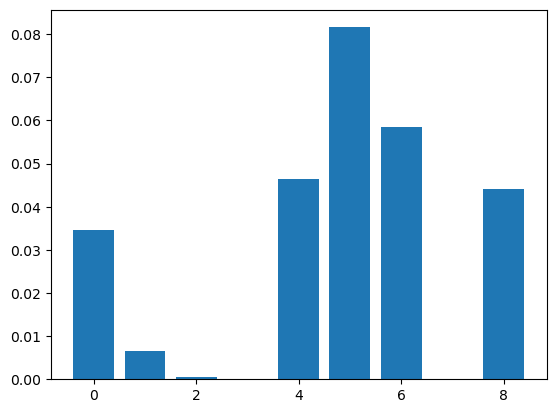

In [12]:
#Using the SelectKBest with mutual_information to find out the best features
mutual_info_fs = SelectKBest(score_func=mutual_info_classif, k='all')
#Here we are specifying k as all for now.Just to plot and visualise all the feature scores.
mutual_info_fs.fit(X_train_enc, Y_train_enc)
X_train_fs = mutual_info_fs.transform(X_train_enc)
X_test_fs = mutual_info_fs.transform(X_test_enc)

#print the scores
for i in range(len(mutual_info_fs.scores_)):
    print("Feature: %d , score: %f" %(i, mutual_info_fs.scores_[i])) #mutual_info  scores for each feature of input
#plotting
plt.bar([i for i in range(len(mutual_info_fs.scores_))], mutual_info_fs.scores_)
plt.show()

#### Observation: 
    Mutual Info is showing different features as best relevant features with target.

In [13]:
#Lets train the model with K=6 best features to check the performance of mutual info feature selection
mutual_info = SelectKBest(score_func=mutual_info_classif, k=6)
mutual_info.fit(X_train_enc, Y_train_enc)
X_train_best_fs = mutual_info.transform(X_train_enc)
X_test_best_fs = mutual_info.transform(X_test_enc)

#Training the Model
cv = KFold(n_splits=10, random_state=0, shuffle=True)
model = LogisticRegression(solver='lbfgs')
score = cross_val_score(model, X_train_best_fs, Y_train_enc, 
                        cv=cv, scoring='accuracy',
                        error_score='raise', n_jobs=-1)
print("CV score %f"%mean(score))
model.fit(X_train_best_fs, Y_train_enc)
y_train_preds = model.predict(X_train_best_fs)
print("Mutual Info - 6 features - Training accuracy: %f" %(accuracy_score(Y_train_enc, y_train_preds)))
y_pred = model.predict(X_test_best_fs)
print("Mutual Info - 6 features - Test accuracy: %f" %(accuracy_score(Y_test_enc, y_pred)))

CV score 0.757895
Mutual Info - 6 features - Training accuracy: 0.763158
Mutual Info - 6 features - Test accuracy: 0.642105


#### Observation:
    Mutual information feature selection performs better compared to chi sqaure in this test.Although all features yield best accuracies in this case.Its always best practice to include feature selection in the inner loop of cv.

#### How to choose the filter based feature selection method based on input and output variables?
    Many models, especially those based on regression slopes and intercepts, will estimate parameters for every term in the model. Because of this, the presence of non-informative variables can add uncertainty to the predictions and reduce the overall effectiveness of the model.So one should be mindful and careful to perform feature selection.
    
    - The choice of statistical measures is highly dependent upon the variable and also target data types(for supervised fs methods).Common data types include numerical (such as height) and categorical (such as a label), although each may be further subdivided such as integer and floating point for numerical variables, and boolean, ordinal, or nominal for categorical variables.
    - It is known that a numerical output variable indicates a regression predictive modeling problem, and a categorical output variable indicates a classification predictive modeling problem.
    -Most of the filter selection techniques are univariate, meaning that they evaluate each predictor/variable in isolation.
    --------------------------------------------------------------
    - I/P, O/P - Categorical / Numerical - Kendall(non-linear, assumes categorical variable as ordinal)
       
       Kendall tau can handle both numeric and categorical input and output variables, as long as they are ordinal, meaning that they have a natural order. For example, you can use Kendall tau to measure the correlation between the rank order of students’ grades and their rank order of satisfaction with the course. Both grades and satisfaction are ordinal variables that can be ranked from low to high. Kendall tau can also handle ties in the ranks of the variables, meaning that some values are equal and have the same rank. There are different variants of Kendall tau that account for ties differently, such as tau-a, tau-b, and tau-c. The most commonly used variant is tau-b, which adjusts for ties by dividing the number of concordant and discordant pairs by the geometric mean of the number of possible pairs for each variable.
    
    - I/P - Categorical(with more than 3 levels) , O/P - Numerical and continuous - Anova(linear) Anova compares the means among three or more groups - numerical i/p, categorical o/p also
    - I/P - Numerical, O/P - Numerical - Pearson's(Linear) / Spearman's (non-linear)
    - I/P - Categorical, O/P - Categorical - Chi Squared / Mutual Info
    
    Note: Mutual info can be used for numerical as well as categorical(data type agnostic)
    
    - --------------Scikit libraries------------------
    - Pearson’s Correlation Coefficient: f_regression()
    - ANOVA: f_classif() - analysis of variance
    - Chi-Squared: chi2()
    - Mutual Information: mutual_info_classif() and mutual_info_regression()
    
    - -------------Scipy libraries---------------------
    - Kendall’s tau - kendalltau
    - Spearman’s rank correlation - spearmanr
    - Pearson's corr coef - pearsonr
    
    ----------Selection Method after choosing the filter method ----------------
    - SelectKBest - Select the top k variables
    - SelectPercentile - Select the top percentile variables
    
    Note : It is best practice to always transform variables.Like categorical variables to ordinal or variables like age to descritize into bins which can be further used as categorical.Once we transform, we can apply any feature selection method as per the need.

In [198]:
# Regression with numerical i/p and o/p example
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

X, y = make_regression(n_samples=100, n_features=100, n_informative=10)
fs = SelectKBest(score_func=f_regression, k=10) #Pearson correlation
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

(100, 10)


In [199]:
#Classification with numerical i/p and categorical o/p
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X, y = make_classification(n_samples=100, n_features=20, n_informative=2)
fs = SelectKBest(score_func=f_classif, k=2) #Anova-F
X_selected = fs.fit_transform(X, y) 
print(X_selected.shape)

(100, 2)


In [14]:
#kendalltau
from numpy.random import rand
from numpy.random import seed
from scipy.stats import kendalltau
# seed random number generator
seed(1)
# prepare data
data1 = rand(1000) * 20
data2 = data1 + (rand(1000) * 10)
# calculate kendall's correlation
coef, p = kendalltau(data1, data2)
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
 print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
 print('Samples are correlated (reject H0) p=%.3f' % p)

Kendall correlation coefficient: 0.709
Samples are correlated (reject H0) p=0.000
